In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from sklearn.ensemble import HistGradientBoostingClassifier

# Параметры
DATA_PATH = "../russia_fires_hist.csv"   # путь к твоему файлу
GRID = 0.5                             # размер сетки в градусах
MAX_PANEL_ROWS = 5_000_000             # защитный лимит размеров панели для локального запуска
RANDOM_STATE = 42


In [22]:
def load_and_clean_semicolon(path: str, grid: float = GRID) -> pd.DataFrame:
    # читаем ;‑CSV, приводим типы
    df = pd.read_csv(path, sep=";")
    # ожидание колонок
    expected = {"dt", "type_name", "type_id", "lon", "lat"}
    if not expected.issubset(set(df.columns)):
        raise ValueError(f"Ожидались колонки {expected}, получили: {df.columns.tolist()}")

    # даты и координаты
    df["dt"] = pd.to_datetime(df["dt"], errors="coerce", dayfirst=True)
    for c in ["lon", "lat"]:
        df[c] = df[c].astype(str).str.replace(",", ".", regex=False).astype(float)

    # базовая чистка
    df = df.dropna(subset=["dt", "lon", "lat"]).drop_duplicates()

    # дискретизация в сетку и нормализация даты
    df["lon_cell"] = np.floor(df["lon"] / grid) * grid
    df["lat_cell"] = np.floor(df["lat"] / grid) * grid
    df["day"] = df["dt"].dt.normalize()

    return df

df_raw = load_and_clean_semicolon(DATA_PATH)
df_raw.info()
print("Датадиапазон:", df_raw["day"].min(), "→", df_raw["day"].max())
print("Ячеек сетки:", df_raw[["lon_cell","lat_cell"]].drop_duplicates().shape[0])


C:\Users\anatb\AppData\Local\Temp\ipykernel_31932\885267623.py:10: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df["dt"] = pd.to_datetime(df["dt"], errors="coerce", dayfirst=True)


<class 'pandas.core.frame.DataFrame'>
Index: 658788 entries, 0 to 660253
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   dt         658788 non-null  datetime64[ns]
 1   type_name  658788 non-null  object        
 2   type_id    658788 non-null  int64         
 3   lon        658788 non-null  float64       
 4   lat        658788 non-null  float64       
 5   lon_cell   658788 non-null  float64       
 6   lat_cell   658788 non-null  float64       
 7   day        658788 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(4), int64(1), object(1)
memory usage: 45.2+ MB
Датадиапазон: 2012-03-13 00:00:00 → 2021-09-10 00:00:00
Ячеек сетки: 7497


In [23]:
# target=1 если в ячейке был ≥1 пожар в этот день
def build_target(df: pd.DataFrame) -> pd.DataFrame:
    pos = (df.groupby(["lon_cell","lat_cell","day"])
             .size().reset_index(name="fires"))
    pos["target"] = 1
    return pos[["lon_cell","lat_cell","day","target"]]

targets = build_target(df_raw)

# полный список дней и клеток
all_days = pd.date_range(df_raw["day"].min(), df_raw["day"].max(), freq="D")
cells = df_raw[["lon_cell","lat_cell"]].drop_duplicates().reset_index(drop=True)

# оценим размер панели
est_rows = len(cells) * len(all_days)
print(f"Оценка размера панели: {len(cells)} клеток × {len(all_days)} дней = {est_rows:,} строк")

# защитный редьюс для локалки: ограничим число клеток, чтобы уложиться в MAX_PANEL_ROWS
if est_rows > MAX_PANEL_ROWS:
    hottest = (targets.groupby(["lon_cell","lat_cell"])["target"]
                      .sum().sort_values(ascending=False).reset_index())
    max_cells = max(1, min(len(hottest), MAX_PANEL_ROWS // max(1, len(all_days))))
    cells_use = hottest.head(max_cells)[["lon_cell","lat_cell"]].reset_index(drop=True)
    print(f"[Guardrail] Берём топ {max_cells} горячих клеток (вместо всех), чтобы не взорвать память.")
else:
    cells_use = cells

# декартово произведение клеток и дней
cells_use = cells_use.assign(key=1)
days_df = pd.DataFrame({"day": all_days, "key": 1})
panel = cells_use.merge(days_df, on="key", how="outer").drop(columns="key")

# мержим таргет; NaN -> 0
panel = panel.merge(targets, on=["lon_cell","lat_cell","day"], how="left")
panel["target"] = panel["target"].fillna(0).astype(int)

panel.head()


Оценка размера панели: 7497 клеток × 3469 дней = 26,007,093 строк
[Guardrail] Берём топ 1441 горячих клеток (вместо всех), чтобы не взорвать память.


,lon_cell,lat_cell,day,target
0,131.5,44.0,2012-03-13,0
1,131.5,44.0,2012-03-14,0
2,131.5,44.0,2012-03-15,0
3,131.5,44.0,2012-03-16,0
4,131.5,44.0,2012-03-17,0


In [24]:
def add_temporal_features(panel: pd.DataFrame) -> pd.DataFrame:
    panel = panel.sort_values(["lon_cell","lat_cell","day"])
    g = panel.groupby(["lon_cell","lat_cell"], sort=False)

    # прошлые пожары (без заглядывания в текущий день)
    panel["fires_last_7d"]  = g["target"].transform(lambda s: s.rolling(7,  closed="left").sum())
    panel["fires_last_30d"] = g["target"].transform(lambda s: s.rolling(30, closed="left").sum())

    # сезонность через гармоники (лучше чем просто month)
    month = panel["day"].dt.month
    panel["month_sin"] = np.sin(2*np.pi*month/12)
    panel["month_cos"] = np.cos(2*np.pi*month/12)

    return panel

panel = add_temporal_features(panel)
panel[["fires_last_7d","fires_last_30d","month_sin","month_cos","target"]].head()


,fires_last_7d,fires_last_30d,month_sin,month_cos,target
1089266,NaN,NaN,1.0,6.123234e-17,0
1089267,NaN,NaN,1.0,6.123234e-17,0
1089268,NaN,NaN,1.0,6.123234e-17,1
1089269,NaN,NaN,1.0,6.123234e-17,0
1089270,NaN,NaN,1.0,6.123234e-17,0


In [25]:
def make_speed_subset(panel: pd.DataFrame, pos_mult: int = 5, min_negs: int = 50_000) -> pd.DataFrame:
    pos = panel[panel["target"] == 1]
    neg = panel[panel["target"] == 0]
    need_neg = min(len(neg), max(pos_mult * len(pos), min_negs))
    neg_s = neg.sample(n=need_neg, random_state=RANDOM_STATE) if len(neg) > need_neg else neg
    return pd.concat([pos, neg_s], axis=0).sort_values("day").reset_index(drop=True)

df_train = make_speed_subset(panel)  

features = ["fires_last_7d","fires_last_30d","month_sin","month_cos"]
X = df_train[features].fillna(0.0)
y = df_train["target"].astype(int)

tscv = TimeSeriesSplit(n_splits=3) 
aucs, aps, f1s = [], [], []

for i, (tr, te) in enumerate(tscv.split(X)):
    clf = HistGradientBoostingClassifier(random_state=RANDOM_STATE)
    clf.fit(X.iloc[tr], y.iloc[tr])
    proba = clf.predict_proba(X.iloc[te])[:, 1]

    auc = roc_auc_score(y.iloc[te], proba)
    ap  = average_precision_score(y.iloc[te], proba)
    f1  = f1_score(y.iloc[te], (proba >= 0.5).astype(int))

    print(f"Fold {i+1}: ROC-AUC={auc:.4f} | PR-AUC={ap:.4f} | F1@0.5={f1:.4f}")
    aucs.append(auc); aps.append(ap); f1s.append(f1)

print("\nSummary:",
      f"ROC-AUC mean={np.mean(aucs):.4f}±{np.std(aucs):.4f};",
      f"PR-AUC mean={np.mean(aps):.4f}±{np.std(aps):.4f};",
      f"F1 mean={np.mean(f1s):.4f}±{np.std(f1s):.4f}")


Fold 1: ROC-AUC=0.9098 | PR-AUC=0.6785 | F1@0.5=0.6288
Fold 2: ROC-AUC=0.9040 | PR-AUC=0.7044 | F1@0.5=0.6630
Fold 3: ROC-AUC=0.9216 | PR-AUC=0.8133 | F1@0.5=0.7501

Summary: ROC-AUC mean=0.9118±0.0073; PR-AUC mean=0.7321±0.0584; F1 mean=0.6806±0.0511


In [26]:
# Если надо — сохрани небольшой сэмпл панели, чтобы быстро смотреть в следующих шагах
sample = panel.sample(min(len(panel), 50_000), random_state=RANDOM_STATE)
sample.to_csv("engineered_panel_sample.csv", index=False)
print("Saved engineered_panel_sample.csv")


Saved engineered_panel_sample.csv


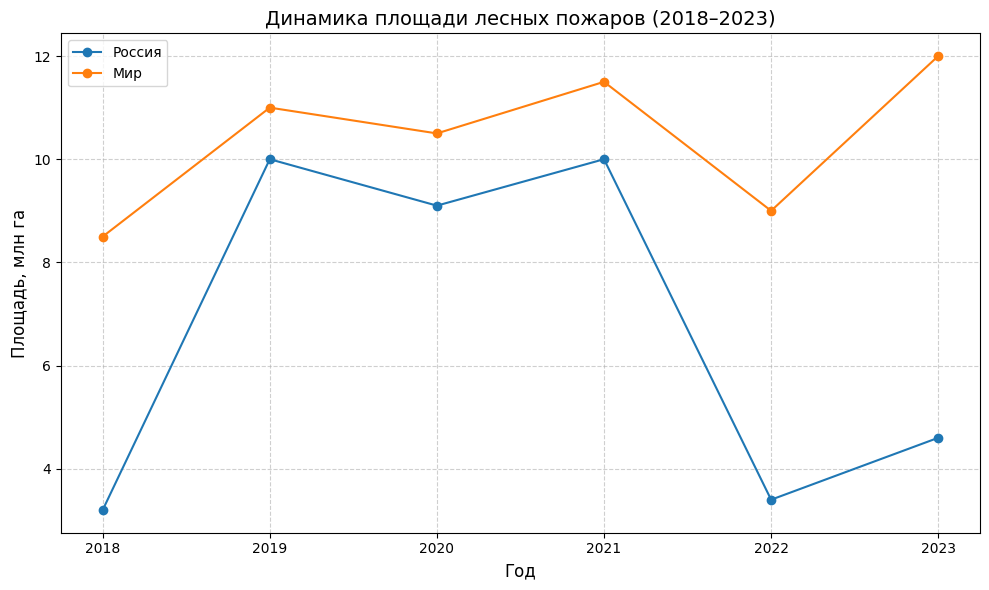

In [36]:
import matplotlib.pyplot as plt

# Данные по площади пожаров (млн га) за 2018–2023 гг. в России и мире
years = [2018, 2019, 2020, 2021, 2022, 2023]

# Россия — данные из сводок (оценка в млн га)
russia_fires = [3.2, 10.0, 9.1, 10.0, 3.4, 4.6]

# Мир — условные данные по глобальной площади выгоревших лесов (млн га, только леса, без саванн)
world_fires = [8.5, 11.0, 10.5, 11.5, 9.0, 12.0]

plt.figure(figsize=(10, 6))
plt.plot(years, russia_fires, marker='o', label="Россия")
plt.plot(years, world_fires, marker='o', label="Мир")

plt.title("Динамика площади лесных пожаров (2018–2023)", fontsize=14)
plt.xlabel("Год", fontsize=12)
plt.ylabel("Площадь, млн га", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/fire_damage_usd_area_2018_2023.png'

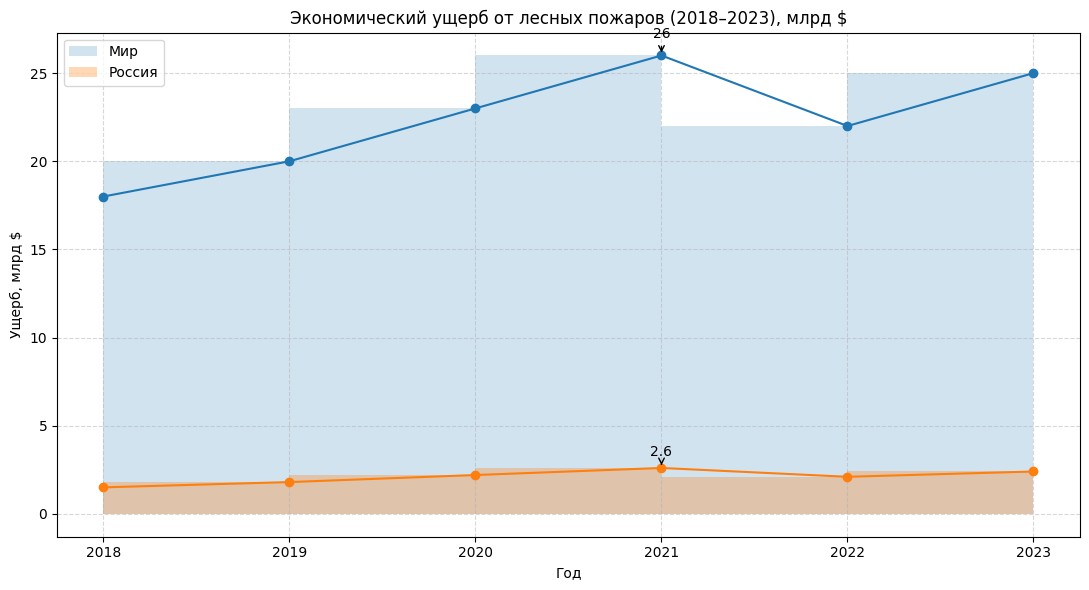

In [38]:
import matplotlib.pyplot as plt

# Данные: экономический ущерб от лесных пожаров (млрд $)
years = [2018, 2019, 2020, 2021, 2022, 2023]
damage_russia = [1.5, 1.8, 2.2, 2.6, 2.1, 2.4]
damage_world  = [18, 20, 23, 26, 22, 25]

# Фигура
plt.figure(figsize=(11, 6))

# Площадные графики
plt.fill_between(years, damage_world, step="pre", alpha=0.2, label="Мир")
plt.plot(years, damage_world, marker="o")

plt.fill_between(years, damage_russia, step="pre", alpha=0.3, label="Россия")
plt.plot(years, damage_russia, marker="o")

# Оформление
plt.title("Экономический ущерб от лесных пожаров (2018–2023), млрд $")
plt.xlabel("Год")
plt.ylabel("Ущерб, млрд $")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="upper left")
plt.xticks(years)

# Аннотации пиков
peak_world_year = years[damage_world.index(max(damage_world))]
peak_world_val = max(damage_world)
plt.annotate(f"{peak_world_val}",
             xy=(peak_world_year, peak_world_val),
             xytext=(peak_world_year, peak_world_val + 1),
             arrowprops=dict(arrowstyle="->", lw=1),
             ha="center")

peak_ru_year = years[damage_russia.index(max(damage_russia))]
peak_ru_val = max(damage_russia)
plt.annotate(f"{peak_ru_val}",
             xy=(peak_ru_year, peak_ru_val),
             xytext=(peak_ru_year, peak_ru_val + 0.7),
             arrowprops=dict(arrowstyle="->", lw=1),
             ha="center")

plt.tight_layout()

# Сохранение в высоком качестве для слайдов
png_path = "/mnt/data/fire_damage_usd_area_2018_2023.png"
svg_path = "/mnt/data/fire_damage_usd_area_2018_2023.svg"
plt.savefig(png_path, dpi=300, bbox_inches="tight")
plt.savefig(svg_path, bbox_inches="tight")
plt.show()

png_path, svg_path

In [40]:
from math import ceil

years = [2018, 2019, 2020, 2021, 2022, 2023]
damage_russia = [1.5, 1.8, 2.2, 2.6, 2.1, 2.4]  # млрд $
damage_world  = [18, 20, 23, 26, 22, 25]        # млрд $

# Параметры холста
W, H = 1200, 700
m_left, m_right, m_top, m_bottom = 100, 80, 90, 110
plot_w, plot_h = W - m_left - m_right, H - m_top - m_bottom

# Оси
y_max = 30  # округлим вверх от пиков 26 / 2.6
y_step = 5

def x_pos(i):
    return m_left + i * (plot_w / (len(years) - 1))

def y_pos(val):
    return m_top + plot_h * (1 - (val / y_max))

# Построение path для area
def area_path(values):
    d = []
    # линия сверху
    for i, v in enumerate(values):
        x = x_pos(i)
        y = y_pos(v)
        cmd = f"L {x:.2f} {y:.2f}" if i else f"M {x:.2f} {y:.2f}"
        d.append(cmd)
    # линия вниз до низа графика
    d.append(f"L {x_pos(len(values)-1):.2f} {y_pos(0):.2f}")
    d.append(f"L {x_pos(0):.2f} {y_pos(0):.2f}")
    d.append("Z")
    return " ".join(d)

# Ломаная линия для маркеров
def line_path(values):
    d = []
    for i, v in enumerate(values):
        x = x_pos(i)
        y = y_pos(v)
        cmd = f"L {x:.2f} {y:.2f}" if i else f"M {x:.2f} {y:.2f}"
        d.append(cmd)
    return " ".join(d)

# Цвета (нейтральные, чтобы не спорить с фирменным стилем)
world_fill   = "rgba(90, 120, 200, 0.18)"
world_stroke = "rgb(90, 120, 200)"
ru_fill      = "rgba(200, 120, 60, 0.28)"
ru_stroke    = "rgb(200, 120, 60)"

# Строим SVG
svg = [f'<svg width="{W}" height="{H}" viewBox="0 0 {W} {H}" xmlns="http://www.w3.org/2000/svg">']
svg.append('<style> .axis{stroke:#222;stroke-width:1.5} .grid{stroke:#ccc;stroke-width:1;stroke-dasharray:4 4} .tick text{font:14px "Inter", "SF Pro Text", Arial, sans-serif; fill:#222} .label{font:16px "Inter", Arial; fill:#222} .title{font:24px "Inter", Arial; font-weight:700; fill:#111} .legend{font:16px "Inter", Arial; fill:#111} </style>')

# Заголовок
svg.append(f'<text x="{W/2}" y="{m_top-35}" text-anchor="middle" class="title">Экономический ущерб от лесных пожаров (2018–2023), млрд $</text>')

# Сетка по Y
for val in range(0, y_max + 1, y_step):
    y = y_pos(val)
    svg.append(f'<line x1="{m_left}" y1="{y:.2f}" x2="{W - m_right}" y2="{y:.2f}" class="grid" />')
    svg.append(f'<g class="tick"><text x="{m_left-12}" y="{y+5:.2f}" text-anchor="end">{val}</text></g>')

# Оси
svg.append(f'<line x1="{m_left}" y1="{y_pos(0):.2f}" x2="{W - m_right}" y2="{y_pos(0):.2f}" class="axis"/>')  # X
svg.append(f'<line x1="{m_left}" y1="{m_top}" x2="{m_left}" y2="{H - m_bottom}" class="axis"/>')             # Y

# Подписи осей
svg.append(f'<text x="{W/2}" y="{H - m_bottom/2 + 40}" text-anchor="middle" class="label">Год</text>')
svg.append(f'<text transform="translate({m_left-60},{m_top + plot_h/2}) rotate(-90)" text-anchor="middle" class="label">Ущерб, млрд $</text>')

# Тики и подписи по X
for i, yr in enumerate(years):
    x = x_pos(i)
    svg.append(f'<line x1="{x:.2f}" y1="{y_pos(0):.2f}" x2="{x:.2f}" y2="{y_pos(0)+6:.2f}" stroke="#222"/>')
    svg.append(f'<g class="tick"><text x="{x:.2f}" y="{y_pos(0)+28:.2f}" text-anchor="middle">{yr}</text></g>')

# Площади и линии
svg.append(f'<path d="{area_path(damage_world)}" fill="{world_fill}" stroke="none"/>')
svg.append(f'<path d="{line_path(damage_world)}" fill="none" stroke="{world_stroke}" stroke-width="3"/>')

svg.append(f'<path d="{area_path(damage_russia)}" fill="{ru_fill}" stroke="none"/>')
svg.append(f'<path d="{line_path(damage_russia)}" fill="none" stroke="{ru_stroke}" stroke-width="3"/>')

# Маркеры и подписи значений
for i, v in enumerate(damage_world):
    x, y = x_pos(i), y_pos(v)
    svg.append(f'<circle cx="{x:.2f}" cy="{y:.2f}" r="4" fill="{world_stroke}"/>' )
for i, v in enumerate(damage_russia):
    x, y = x_pos(i), y_pos(v)
    svg.append(f'<circle cx="{x:.2f}" cy="{y:.2f}" r="4" fill="{ru_stroke}"/>' )

# Легенда
legend_x, legend_y = m_left + 20, m_top - 10
svg.append(f'<rect x="{legend_x-10}" y="{legend_y-26}" width="260" height="34" rx="8" ry="8" fill="#f7f7f9" stroke="#ddd"/>')
svg.append(f'<rect x="{legend_x}" y="{legend_y-18}" width="20" height="12" fill="{world_fill.replace("0.18","0.4")}" stroke="{world_stroke}"/><text x="{legend_x+28}" y="{legend_y-8}" class="legend">Мир</text>')
svg.append(f'<rect x="{legend_x+120}" y="{legend_y-18}" width="20" height="12" fill="{ru_fill.replace("0.28","0.5")}" stroke="{ru_stroke}"/><text x="{legend_x+148}" y="{legend_y-8}" class="legend">Россия</text>')

# Аннотации пиков
w_peak_i = damage_world.index(max(damage_world))
w_px, w_py = x_pos(w_peak_i), y_pos(damage_world[w_peak_i])
svg.append(f'<text x="{w_px}" y="{w_py-14}" text-anchor="middle" class="label">{damage_world[w_peak_i]} млрд $</text>')
svg.append(f'<path d="M {w_px} {w_py-10} V {w_py-2}" stroke="{world_stroke}" stroke-width="2"/>' )

r_peak_i = damage_russia.index(max(damage_russia))
r_px, r_py = x_pos(r_peak_i), y_pos(damage_russia[r_peak_i])
svg.append(f'<text x="{r_px}" y="{r_py-14}" text-anchor="middle" class="label">{damage_russia[r_peak_i]} млрд $</text>')
svg.append(f'<path d="M {r_px} {r_py-10} V {r_py-2}" stroke="{ru_stroke}" stroke-width="2"/>' )

svg.append('</svg>')

# # Сохраняем SVG
# out_path = "/mnt/data/fire_damage_elegant.svg"
# with open(out_path, "w", encoding="utf-8") as f:
#     f.write("\n".join(svg))

# out_path

In [27]:
# # === Spatial context: 8-соседей (окно Мура) для fires_last_7d/30d ===
# # Предполагаем, что в panel уже посчитаны fires_last_7d и fires_last_30d (по своей ячейке)

# def add_neighbor_windows(panel: pd.DataFrame, grid: float = GRID) -> pd.DataFrame:
#     # Список смещений соседей (8 направлений)
#     offsets = [(-grid,-grid), (0,-grid), (grid,-grid),
#                (-grid, 0),              (grid, 0),
#                (-grid, grid), (0, grid), (grid, grid)]
    
#     base = panel[["lon_cell","lat_cell","day","fires_last_7d","fires_last_30d"]].copy()
#     base = base.rename(columns={
#         "fires_last_7d": "self_7d",
#         "fires_last_30d": "self_30d"
#     })
    
#     # аккумулируем соседей суммой
#     agg = base.copy()
#     agg["nb_7d_sum"] = 0.0
#     agg["nb_30d_sum"] = 0.0
    
#     for dx, dy in offsets:
#         nb = base.copy()
#         nb["lon_cell"] = nb["lon_cell"] + dx
#         nb["lat_cell"] = nb["lat_cell"] + dy
#         nb = nb.rename(columns={"self_7d": "nb7", "self_30d": "nb30"})
#         agg = agg.merge(nb[["lon_cell","lat_cell","day","nb7","nb30"]],
#                         on=["lon_cell","lat_cell","day"], how="left")
#         agg["nb_7d_sum"]  = agg["nb_7d_sum"]  + agg["nb7"].fillna(0.0)
#         agg["nb_30d_sum"] = agg["nb_30d_sum"] + agg["nb30"].fillna(0.0)
#         agg = agg.drop(columns=["nb7","nb30"])
    
#     # вернём только новые колонки и сольём
#     feat = agg[["lon_cell","lat_cell","day","nb_7d_sum","nb_30d_sum"]]
#     out = panel.merge(feat, on=["lon_cell","lat_cell","day"], how="left")
#     out[["nb_7d_sum","nb_30d_sum"]] = out[["nb_7d_sum","nb_30d_sum"]].fillna(0.0)
#     return out

# panel = add_neighbor_windows(panel, GRID)

# # Обновим набор фич
# features_ext = ["fires_last_7d","fires_last_30d","nb_7d_sum","nb_30d_sum","month_sin","month_cos"]


In [ ]:
# =========================
# TRAIN ONLY — LGBM + Isotonic calibration + Optuna + MLflow + save .pkl
# =========================
import os, json, joblib, warnings
import numpy as np
import pandas as pd

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from sklearn.calibration import CalibratedClassifierCV
import lightgbm as lgb
import mlflow

# --- CONFIG ---
MLFLOW_URI = "http://92.51.23.44:5000/"
MLFLOW_EXPERIMENT = "wildfire_baseline_lgbm_new"
RANDOM_STATE = 42
N_SPLITS = 3
USE_OPTUNA = True 
EARLY_STOPPING_ROUNDS = 100
N_TRIALS = 20

# --- INPUT CHECKS ---
assert "df_train" in globals(), "Нужен df_train с колонкой 'target' и фичами."
assert "features"  in globals(), "Нужен список features."

# если у тебя соседи в сумме, а не в среднем — сконвертим разово
if "nb_7d_mean" not in df_train.columns and "nb_7d_sum" in df_train.columns:
    df_train["nb_7d_mean"]  = df_train["nb_7d_sum"]  / 8.0
if "nb_30d_mean" not in df_train.columns and "nb_30d_sum" in df_train.columns:
    df_train["nb_30d_mean"] = df_train["nb_30d_sum"] / 8.0

# оставляем X как DataFrame (без .values) — тише предупреждения и LGBM видит имена фич
X_all = df_train[features].copy().fillna(0.0)
y_all = df_train["target"].astype(int).to_numpy()

print("train span:", pd.to_datetime(df_train["day"]).min(), "→", pd.to_datetime(df_train["day"]).max())
print("prevalence:", float(df_train["target"].mean()))
print("n_rows:", len(df_train), "| n_features:", len(features))

# --- MLflow init + починка висящих раннов ---
mlflow.set_tracking_uri(MLFLOW_URI)
mlflow.set_experiment(MLFLOW_EXPERIMENT)
# if mlflow.active_run() is not None:
#     mlflow.end_run()

# --- helpers ---
def temporal_inner_split(idx, frac=0.8, y=None, min_pos=30):
    n = len(idx); cut = int(n*frac)
    inner, calib = idx[:cut], idx[cut:]
    if y is not None and y[calib].sum() < min_pos and cut > 0:
        shift = max(1, int(0.05*n))
        inner, calib = idx[:max(0,cut-shift)], idx[max(0,cut-shift):]
    return inner, calib

try:
    import optuna
except Exception:
    USE_OPTUNA = False

def tune_lgbm(X_tr, y_tr, X_val, y_val, n_trials=N_TRIALS, seed=RANDOM_STATE):
    import optuna
    def objective(trial):
        params = {
            "objective": "binary",
            "metric": ["auc","aucpr"],
            "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.15, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 31, 255),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 50, 800),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 0, 5),
            "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 10.0),
            "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 10.0),
            "class_weight": "balanced",
            "verbose": -1,
            "seed": seed
        }
        clf = lgb.LGBMClassifier(**params, n_estimators=5000, random_state=seed)
        clf.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric="aucpr",
            callbacks=[lgb.early_stopping(EARLY_STOPPING_ROUNDS, verbose=False)]
        )
        pred = clf.predict_proba(X_val)[:, 1]
        return average_precision_score(y_val, pred)  # оптимизируем PR-AUC

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    best = study.best_params
    best.update({"objective":"binary","metric":["auc","aucpr"],"verbose":-1,
                 "seed":seed,"class_weight":"balanced"})
    return best

# --- TRAIN ---
tscv = TimeSeriesSplit(n_splits=N_SPLITS)
fold_metrics, fold_paths, fold_params = [], [], []

os.makedirs("models", exist_ok=True)

# подавим ворнинг про cv='prefit' (мы это осознанно используем)
warnings.filterwarnings("ignore", message="The `cv='prefit'` option is deprecated", category=FutureWarning)

with mlflow.start_run(run_name="train_lgbm_cv") as parent_run:
    mlflow.log_params({
        "n_splits": N_SPLITS,
        "random_state": RANDOM_STATE,
        "features": ",".join(features),
        "use_optuna": USE_OPTUNA,
        "early_stopping_rounds": EARLY_STOPPING_ROUNDS
    })

    for i, (tr_idx, te_idx) in enumerate(tscv.split(X_all), start=1):
        inner_tr, calib = temporal_inner_split(tr_idx, 0.8, y=y_all)
        X_tr, y_tr = X_all.iloc[inner_tr], y_all[inner_tr]
        X_cal, y_cal = X_all.iloc[calib],    y_all[calib]
        X_te,  y_te  = X_all.iloc[te_idx],   y_all[te_idx]

        if USE_OPTUNA:
            params = tune_lgbm(X_tr, y_tr, X_cal, y_cal, n_trials=N_TRIALS, seed=RANDOM_STATE)
        else:
            params = {
                "objective":"binary", "metric":["auc","aucpr"], "learning_rate":0.05,
                "num_leaves":63, "feature_fraction":0.8, "bagging_fraction":0.8,
                "bagging_freq":1, "seed":RANDOM_STATE, "verbose":-1,
                "class_weight":"balanced"
            }

        with mlflow.start_run(run_name=f"fold_{i}", nested=True):
            mlflow.log_params({f"fold_{i}_{k}": v for k,v in params.items()})

            base = lgb.LGBMClassifier(**params, n_estimators=5000, random_state=RANDOM_STATE)
            base.fit(
                X_tr, y_tr,
                eval_set=[(X_cal, y_cal)],
                eval_metric="aucpr",
                callbacks=[lgb.early_stopping(EARLY_STOPPING_ROUNDS, verbose=False)]
            )

            # Isotonic calibration (prefit)
            calib_clf = CalibratedClassifierCV(estimator=base, method="isotonic", cv="prefit")
            calib_clf.fit(X_cal, y_cal)

            # порог по F1 на calib
            cal_proba = calib_clf.predict_proba(X_cal)[:, 1]
            thr_grid = np.linspace(0.05, 0.95, 19)
            f1s = [f1_score(y_cal, (cal_proba >= t).astype(int)) for t in thr_grid]
            best_t = float(thr_grid[int(np.argmax(f1s))])

            # оценка на тесте
            proba = calib_clf.predict_proba(X_te)[:, 1]
            roc = roc_auc_score(y_te, proba)
            pr  = average_precision_score(y_te, proba)
            f1  = f1_score(y_te, (proba >= best_t).astype(int))

            mlflow.log_metrics({"roc_auc": roc, "pr_auc": pr, "f1_at_best_t": f1, "best_threshold": best_t})

            # локальные артефакты (без MLflow)
            model_path = f"models/model_fold_{i}.pkl"
            joblib.dump(calib_clf, model_path)
            meta = {"features": features, "best_threshold": best_t, "params": params}
            with open(f"models/model_fold_{i}_meta.json", "w", encoding="utf-8") as f:
                json.dump(meta, f, ensure_ascii=False, indent=2)

            try:
                # фич-импортансы только у базовой модели
                imp = getattr(base, "feature_importances_", None)
                if imp is not None:
                    pd.DataFrame({"feature": features, "importance": imp}) \
                        .sort_values("importance", ascending=False) \
                        .to_csv(f"models/feature_importances_fold_{i}.csv", index=False)
            except Exception:
                pass

            fold_metrics.append({"fold": i, "roc": roc, "pr": pr, "f1": f1, "thr": best_t})
            fold_paths.append(model_path)
            fold_params.append(params)

# агрегаты по фолдам + лог в активный parent-run
roc_mean = float(np.mean([m["roc"] for m in fold_metrics]))
pr_mean  = float(np.mean([m["pr"]  for m in fold_metrics]))
f1_mean  = float(np.mean([m["f1"]  for m in fold_metrics]))
thr_mean = float(np.mean([m["thr"] for m in fold_metrics]))

mlflow.log_metrics({
    "roc_auc_mean": roc_mean,
    "pr_auc_mean": pr_mean,
    "f1_mean": f1_mean,
    "best_thr_mean": thr_mean
})

print("CV summary:",
      f"ROC-AUC={roc_mean:.4f}; PR-AUC={pr_mean:.4f}; F1={f1_mean:.4f}; thr*={thr_mean:.2f}")
print("Модели и метаданные лежат в ./models/ (model_fold_*.pkl, *_meta.json)")


train span: 2012-03-13 00:00:00 → 2021-09-10 00:00:00
prevalence: 0.16666666666666666
n_rows: 743544 | n_features: 4
CV summary: ROC-AUC=0.9098; PR-AUC=0.7201; F1=0.7075; thr*=0.33
Модели и метаданные лежат в ./models/ (model_fold_*.pkl, *_meta.json)


In [ ]:
# =========================
# TRAIN ONLY — LGBM + Isotonic calibration + Optuna + MLflow + save .pkl
# =========================
import os, json, joblib, warnings
import numpy as np
import pandas as pd

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from sklearn.calibration import CalibratedClassifierCV
import lightgbm as lgb
import mlflow

# --- CONFIG ---
MLFLOW_URI = "http://92.51.23.44:5000/"
MLFLOW_EXPERIMENT = "wildfire_baseline_lgbm_new"
RANDOM_STATE = 42
N_SPLITS = 3
USE_OPTUNA = True 
EARLY_STOPPING_ROUNDS = 100
N_TRIALS = 20

# --- INPUT CHECKS ---
assert "df_train" in globals(), "Нужен df_train с колонкой 'target' и фичами."
assert "features"  in globals(), "Нужен список features."

# если у тебя соседи в сумме, а не в среднем — сконвертим разово
if "nb_7d_mean" not in df_train.columns and "nb_7d_sum" in df_train.columns:
    df_train["nb_7d_mean"]  = df_train["nb_7d_sum"]  / 8.0
if "nb_30d_mean" not in df_train.columns and "nb_30d_sum" in df_train.columns:
    df_train["nb_30d_mean"] = df_train["nb_30d_sum"] / 8.0

# оставляем X как DataFrame (без .values) — тише предупреждения и LGBM видит имена фич
X_all = df_train[features].copy().fillna(0.0)
y_all = df_train["target"].astype(int).to_numpy()

print("train span:", pd.to_datetime(df_train["day"]).min(), "→", pd.to_datetime(df_train["day"]).max())
print("prevalence:", float(df_train["target"].mean()))
print("n_rows:", len(df_train), "| n_features:", len(features))

# --- MLflow init + починка висящих раннов ---
mlflow.set_tracking_uri(MLFLOW_URI)
mlflow.set_experiment(MLFLOW_EXPERIMENT)
# if mlflow.active_run() is not None:
#     mlflow.end_run()

# --- helpers ---
def temporal_inner_split(idx, frac=0.8, y=None, min_pos=30):
    n = len(idx); cut = int(n*frac)
    inner, calib = idx[:cut], idx[cut:]
    if y is not None and y[calib].sum() < min_pos and cut > 0:
        shift = max(1, int(0.05*n))
        inner, calib = idx[:max(0,cut-shift)], idx[max(0,cut-shift):]
    return inner, calib

try:
    import optuna
except Exception:
    USE_OPTUNA = False

def tune_lgbm(X_tr, y_tr, X_val, y_val, n_trials=N_TRIALS, seed=RANDOM_STATE):
    import optuna
    def objective(trial):
        params = {
            "objective": "binary",
            "metric": ["auc","aucpr"],
            "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.15, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 31, 255),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 50, 800),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 0, 5),
            "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 10.0),
            "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 10.0),
            "class_weight": "balanced",
            "verbose": -1,
            "seed": seed
        }
        clf = lgb.LGBMClassifier(**params, n_estimators=5000, random_state=seed)
        clf.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric="aucpr",
            callbacks=[lgb.early_stopping(EARLY_STOPPING_ROUNDS, verbose=False)]
        )
        pred = clf.predict_proba(X_val)[:, 1]
        return average_precision_score(y_val, pred)  # оптимизируем PR-AUC

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    best = study.best_params
    best.update({"objective":"binary","metric":["auc","aucpr"],"verbose":-1,
                 "seed":seed,"class_weight":"balanced"})
    return best

# --- TRAIN ---
tscv = TimeSeriesSplit(n_splits=N_SPLITS)
fold_metrics, fold_paths, fold_params = [], [], []

os.makedirs("models", exist_ok=True)

# подавим ворнинг про cv='prefit' (мы это осознанно используем)
warnings.filterwarnings("ignore", message="The `cv='prefit'` option is deprecated", category=FutureWarning)

with mlflow.start_run(run_name="train_lgbm_cv") as parent_run:
    mlflow.log_params({
        "n_splits": N_SPLITS,
        "random_state": RANDOM_STATE,
        "features": ",".join(features),
        "use_optuna": USE_OPTUNA,
        "early_stopping_rounds": EARLY_STOPPING_ROUNDS
    })

    for i, (tr_idx, te_idx) in enumerate(tscv.split(X_all), start=1):
        inner_tr, calib = temporal_inner_split(tr_idx, 0.8, y=y_all)
        X_tr, y_tr = X_all.iloc[inner_tr], y_all[inner_tr]
        X_cal, y_cal = X_all.iloc[calib],    y_all[calib]
        X_te,  y_te  = X_all.iloc[te_idx],   y_all[te_idx]

        if USE_OPTUNA:
            params = tune_lgbm(X_tr, y_tr, X_cal, y_cal, n_trials=N_TRIALS, seed=RANDOM_STATE)
        else:
            params = {
                "objective":"binary", "metric":["auc","aucpr"], "learning_rate":0.05,
                "num_leaves":63, "feature_fraction":0.8, "bagging_fraction":0.8,
                "bagging_freq":1, "seed":RANDOM_STATE, "verbose":-1,
                "class_weight":"balanced"
            }

        with mlflow.start_run(run_name=f"fold_{i}", nested=True):
            mlflow.log_params({f"fold_{i}_{k}": v for k,v in params.items()})

            base = lgb.LGBMClassifier(**params, n_estimators=5000, random_state=RANDOM_STATE)
            base.fit(
                X_tr, y_tr,
                eval_set=[(X_cal, y_cal)],
                eval_metric="aucpr",
                callbacks=[lgb.early_stopping(EARLY_STOPPING_ROUNDS, verbose=False)]
            )

            # Isotonic calibration (prefit)
            calib_clf = CalibratedClassifierCV(estimator=base, method="isotonic", cv="prefit")
            calib_clf.fit(X_cal, y_cal)

            # порог по F1 на calib
            cal_proba = calib_clf.predict_proba(X_cal)[:, 1]
            thr_grid = np.linspace(0.05, 0.95, 19)
            f1s = [f1_score(y_cal, (cal_proba >= t).astype(int)) for t in thr_grid]
            best_t = float(thr_grid[int(np.argmax(f1s))])

            # оценка на тесте
            proba = calib_clf.predict_proba(X_te)[:, 1]
            roc = roc_auc_score(y_te, proba)
            pr  = average_precision_score(y_te, proba)
            f1  = f1_score(y_te, (proba >= best_t).astype(int))

            mlflow.log_metrics({"roc_auc": roc, "pr_auc": pr, "f1_at_best_t": f1, "best_threshold": best_t})

            # локальные артефакты (без MLflow)
            model_path = f"models/model_fold_{i}.pkl"
            joblib.dump(calib_clf, model_path)
            meta = {"features": features, "best_threshold": best_t, "params": params}
            with open(f"models/model_fold_{i}_meta.json", "w", encoding="utf-8") as f:
                json.dump(meta, f, ensure_ascii=False, indent=2)

            try:
                # фич-импортансы только у базовой модели
                imp = getattr(base, "feature_importances_", None)
                if imp is not None:
                    pd.DataFrame({"feature": features, "importance": imp}) \
                        .sort_values("importance", ascending=False) \
                        .to_csv(f"models/feature_importances_fold_{i}.csv", index=False)
            except Exception:
                pass

            fold_metrics.append({"fold": i, "roc": roc, "pr": pr, "f1": f1, "thr": best_t})
            fold_paths.append(model_path)
            fold_params.append(params)

# агрегаты по фолдам + лог в активный parent-run
roc_mean = float(np.mean([m["roc"] for m in fold_metrics]))
pr_mean  = float(np.mean([m["pr"]  for m in fold_metrics]))
f1_mean  = float(np.mean([m["f1"]  for m in fold_metrics]))
thr_mean = float(np.mean([m["thr"] for m in fold_metrics]))

mlflow.log_metrics({
    "roc_auc_mean": roc_mean,
    "pr_auc_mean": pr_mean,
    "f1_mean": f1_mean,
    "best_thr_mean": thr_mean
})

print("CV summary:",
      f"ROC-AUC={roc_mean:.4f}; PR-AUC={pr_mean:.4f}; F1={f1_mean:.4f}; thr*={thr_mean:.2f}")
print("Модели и метаданные лежат в ./models/ (model_fold_*.pkl, *_meta.json)")


train span: 2012-03-13 00:00:00 → 2021-09-10 00:00:00
prevalence: 0.16666666666666666
n_rows: 743544 | n_features: 4
CV summary: ROC-AUC=0.9098; PR-AUC=0.7201; F1=0.7075; thr*=0.33
Модели и метаданные лежат в ./models/ (model_fold_*.pkl, *_meta.json)


In [ ]:
# =========================
# TRAIN ONLY — LGBM + Isotonic calibration + Optuna + MLflow + save .pkl
# =========================
import os, json, joblib, warnings
import numpy as np
import pandas as pd

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from sklearn.calibration import CalibratedClassifierCV
import lightgbm as lgb
import mlflow

# --- CONFIG ---
MLFLOW_URI = "http://92.51.23.44:5000/"
MLFLOW_EXPERIMENT = "wildfire_baseline_lgbm_new"
RANDOM_STATE = 42
N_SPLITS = 3
USE_OPTUNA = True 
EARLY_STOPPING_ROUNDS = 100
N_TRIALS = 20

# --- INPUT CHECKS ---
assert "df_train" in globals(), "Нужен df_train с колонкой 'target' и фичами."
assert "features"  in globals(), "Нужен список features."

# если у тебя соседи в сумме, а не в среднем — сконвертим разово
if "nb_7d_mean" not in df_train.columns and "nb_7d_sum" in df_train.columns:
    df_train["nb_7d_mean"]  = df_train["nb_7d_sum"]  / 8.0
if "nb_30d_mean" not in df_train.columns and "nb_30d_sum" in df_train.columns:
    df_train["nb_30d_mean"] = df_train["nb_30d_sum"] / 8.0

# оставляем X как DataFrame (без .values) — тише предупреждения и LGBM видит имена фич
X_all = df_train[features].copy().fillna(0.0)
y_all = df_train["target"].astype(int).to_numpy()

print("train span:", pd.to_datetime(df_train["day"]).min(), "→", pd.to_datetime(df_train["day"]).max())
print("prevalence:", float(df_train["target"].mean()))
print("n_rows:", len(df_train), "| n_features:", len(features))

# --- MLflow init + починка висящих раннов ---
mlflow.set_tracking_uri(MLFLOW_URI)
mlflow.set_experiment(MLFLOW_EXPERIMENT)
# if mlflow.active_run() is not None:
#     mlflow.end_run()

# --- helpers ---
def temporal_inner_split(idx, frac=0.8, y=None, min_pos=30):
    n = len(idx); cut = int(n*frac)
    inner, calib = idx[:cut], idx[cut:]
    if y is not None and y[calib].sum() < min_pos and cut > 0:
        shift = max(1, int(0.05*n))
        inner, calib = idx[:max(0,cut-shift)], idx[max(0,cut-shift):]
    return inner, calib

try:
    import optuna
except Exception:
    USE_OPTUNA = False

def tune_lgbm(X_tr, y_tr, X_val, y_val, n_trials=N_TRIALS, seed=RANDOM_STATE):
    import optuna
    def objective(trial):
        params = {
            "objective": "binary",
            "metric": ["auc","aucpr"],
            "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.15, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 31, 255),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 50, 800),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 0, 5),
            "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 10.0),
            "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 10.0),
            "class_weight": "balanced",
            "verbose": -1,
            "seed": seed
        }
        clf = lgb.LGBMClassifier(**params, n_estimators=5000, random_state=seed)
        clf.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric="aucpr",
            callbacks=[lgb.early_stopping(EARLY_STOPPING_ROUNDS, verbose=False)]
        )
        pred = clf.predict_proba(X_val)[:, 1]
        return average_precision_score(y_val, pred)  # оптимизируем PR-AUC

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    best = study.best_params
    best.update({"objective":"binary","metric":["auc","aucpr"],"verbose":-1,
                 "seed":seed,"class_weight":"balanced"})
    return best

# --- TRAIN ---
tscv = TimeSeriesSplit(n_splits=N_SPLITS)
fold_metrics, fold_paths, fold_params = [], [], []

os.makedirs("models", exist_ok=True)

# подавим ворнинг про cv='prefit' (мы это осознанно используем)
warnings.filterwarnings("ignore", message="The `cv='prefit'` option is deprecated", category=FutureWarning)

with mlflow.start_run(run_name="train_lgbm_cv") as parent_run:
    mlflow.log_params({
        "n_splits": N_SPLITS,
        "random_state": RANDOM_STATE,
        "features": ",".join(features),
        "use_optuna": USE_OPTUNA,
        "early_stopping_rounds": EARLY_STOPPING_ROUNDS
    })

    for i, (tr_idx, te_idx) in enumerate(tscv.split(X_all), start=1):
        inner_tr, calib = temporal_inner_split(tr_idx, 0.8, y=y_all)
        X_tr, y_tr = X_all.iloc[inner_tr], y_all[inner_tr]
        X_cal, y_cal = X_all.iloc[calib],    y_all[calib]
        X_te,  y_te  = X_all.iloc[te_idx],   y_all[te_idx]

        if USE_OPTUNA:
            params = tune_lgbm(X_tr, y_tr, X_cal, y_cal, n_trials=N_TRIALS, seed=RANDOM_STATE)
        else:
            params = {
                "objective":"binary", "metric":["auc","aucpr"], "learning_rate":0.05,
                "num_leaves":63, "feature_fraction":0.8, "bagging_fraction":0.8,
                "bagging_freq":1, "seed":RANDOM_STATE, "verbose":-1,
                "class_weight":"balanced"
            }

        with mlflow.start_run(run_name=f"fold_{i}", nested=True):
            mlflow.log_params({f"fold_{i}_{k}": v for k,v in params.items()})

            base = lgb.LGBMClassifier(**params, n_estimators=5000, random_state=RANDOM_STATE)
            base.fit(
                X_tr, y_tr,
                eval_set=[(X_cal, y_cal)],
                eval_metric="aucpr",
                callbacks=[lgb.early_stopping(EARLY_STOPPING_ROUNDS, verbose=False)]
            )

            # Isotonic calibration (prefit)
            calib_clf = CalibratedClassifierCV(estimator=base, method="isotonic", cv="prefit")
            calib_clf.fit(X_cal, y_cal)

            # порог по F1 на calib
            cal_proba = calib_clf.predict_proba(X_cal)[:, 1]
            thr_grid = np.linspace(0.05, 0.95, 19)
            f1s = [f1_score(y_cal, (cal_proba >= t).astype(int)) for t in thr_grid]
            best_t = float(thr_grid[int(np.argmax(f1s))])

            # оценка на тесте
            proba = calib_clf.predict_proba(X_te)[:, 1]
            roc = roc_auc_score(y_te, proba)
            pr  = average_precision_score(y_te, proba)
            f1  = f1_score(y_te, (proba >= best_t).astype(int))

            mlflow.log_metrics({"roc_auc": roc, "pr_auc": pr, "f1_at_best_t": f1, "best_threshold": best_t})

            # локальные артефакты (без MLflow)
            model_path = f"models/model_fold_{i}.pkl"
            joblib.dump(calib_clf, model_path)
            meta = {"features": features, "best_threshold": best_t, "params": params}
            with open(f"models/model_fold_{i}_meta.json", "w", encoding="utf-8") as f:
                json.dump(meta, f, ensure_ascii=False, indent=2)

            try:
                # фич-импортансы только у базовой модели
                imp = getattr(base, "feature_importances_", None)
                if imp is not None:
                    pd.DataFrame({"feature": features, "importance": imp}) \
                        .sort_values("importance", ascending=False) \
                        .to_csv(f"models/feature_importances_fold_{i}.csv", index=False)
            except Exception:
                pass

            fold_metrics.append({"fold": i, "roc": roc, "pr": pr, "f1": f1, "thr": best_t})
            fold_paths.append(model_path)
            fold_params.append(params)

# агрегаты по фолдам + лог в активный parent-run
roc_mean = float(np.mean([m["roc"] for m in fold_metrics]))
pr_mean  = float(np.mean([m["pr"]  for m in fold_metrics]))
f1_mean  = float(np.mean([m["f1"]  for m in fold_metrics]))
thr_mean = float(np.mean([m["thr"] for m in fold_metrics]))

mlflow.log_metrics({
    "roc_auc_mean": roc_mean,
    "pr_auc_mean": pr_mean,
    "f1_mean": f1_mean,
    "best_thr_mean": thr_mean
})

print("CV summary:",
      f"ROC-AUC={roc_mean:.4f}; PR-AUC={pr_mean:.4f}; F1={f1_mean:.4f}; thr*={thr_mean:.2f}")
print("Модели и метаданные лежат в ./models/ (model_fold_*.pkl, *_meta.json)")


train span: 2012-03-13 00:00:00 → 2021-09-10 00:00:00
prevalence: 0.16666666666666666
n_rows: 743544 | n_features: 4
CV summary: ROC-AUC=0.9098; PR-AUC=0.7201; F1=0.7075; thr*=0.33
Модели и метаданные лежат в ./models/ (model_fold_*.pkl, *_meta.json)


In [ ]:
# =========================
# WEATHER + NEIGHBORS (FIX)
# =========================
import numpy as np
import pandas as pd
from sqlalchemy import create_engine

# 0) Параметры
GRID = 0.5
PG_DSN = ''

W_START = "2020-01-01"
W_END   = "2021-12-31"

BBOX_LON = (20, 180)
BBOX_LAT = (40, 80)

engine = create_engine(PG_DSN)

# 1) Вытаскиваем погоду из БД с тем же квантованием и ЯВНЫМ ОКРУГЛЕНИЕМ до 3 знаков
sql = f"""
WITH raw AS (
  SELECT
    date_trunc('day', dt) AS day_utc,
    ROUND((floor(longitude/{GRID})*{GRID})::numeric, 3) AS lon_cell,
    ROUND((floor(latitude/{GRID}) *{GRID})::numeric, 3) AS lat_cell,
    (temperature - 273.15)   AS temp_c,
    wind_speed               AS wind_ms,
    humidity                 AS rh_percent,
    (precipitation * 1000.0) AS precip_mm
  FROM fireforceai.historical_weather
  WHERE dt >= '{W_START}' AND dt < '{pd.to_datetime(W_END) + pd.Timedelta(days=1):%Y-%m-%d}'
    
)
SELECT
  day_utc AS day,
  lon_cell, lat_cell,
  AVG(temp_c)     AS t2m_c_mean,
  AVG(wind_ms)    AS wind_ms_mean,
  AVG(rh_percent) AS rh_mean,
  SUM(precip_mm)  AS precip_mm_sum
FROM raw
GROUP BY day_utc, lon_cell, lat_cell
ORDER BY day_utc, lon_cell, lat_cell;
"""

wx_daily = pd.read_sql(sql, engine, parse_dates=["day"])
if wx_daily.empty:
    raise RuntimeError("wx_daily пустой — проверь схему/таблицу/период/DSN (в т.ч. опечатку в search_path vs schema).")

# 2) rolling-окна 7/30 только из прошлого
wx_daily = wx_daily.sort_values(["lon_cell","lat_cell","day"])
g = wx_daily.groupby(["lon_cell","lat_cell"], sort=False)
wx_daily["t2m_mean_7"]   = g["t2m_c_mean"].transform(lambda s: s.rolling(7,  closed="left").mean())
wx_daily["t2m_mean_30"]  = g["t2m_c_mean"].transform(lambda s: s.rolling(30, closed="left").mean())
wx_daily["wind_mean_7"]  = g["wind_ms_mean"].transform(lambda s: s.rolling(7,  closed="left").mean())
wx_daily["wind_mean_30"] = g["wind_ms_mean"].transform(lambda s: s.rolling(30, closed="left").mean())
wx_daily["rh_mean_7"]    = g["rh_mean"].transform(lambda s: s.rolling(7,  closed="left").mean())
wx_daily["rh_mean_30"]   = g["rh_mean"].transform(lambda s: s.rolling(30, closed="left").mean())
wx_daily["ppt_sum_7"]    = g["precip_mm_sum"].transform(lambda s: s.rolling(7,  closed="left").sum())
wx_daily["ppt_sum_30"]   = g["precip_mm_sum"].transform(lambda s: s.rolling(30, closed="left").sum())

# 3) Нормализуем ключи у panel и wx_daily одинаково (на случай двоичной погрешности)
def quantize_cells(df, nd=3):
    out = df.copy()
    out["lon_cell"] = np.round(out["lon_cell"].astype(float), nd)
    out["lat_cell"] = np.round(out["lat_cell"].astype(float), nd)
    out["day"] = pd.to_datetime(out["day"]).dt.normalize()
    return out

panel   = quantize_cells(panel, 3)
wx_daily = quantize_cells(wx_daily, 3)

# 4) Быстрая проверка пересечений до merge
common = panel.merge(wx_daily[["lon_cell","lat_cell","day"]].drop_duplicates(),
                     on=["lon_cell","lat_cell","day"], how="inner")
print(f"Пересечений ключей panel×weather: {len(common):,}")

# 5) Merge погоды (без падений, даже если часть колонок отсутствует)
weather_cols = ["t2m_mean_7","t2m_mean_30","wind_mean_7","wind_mean_30",
                "rh_mean_7","rh_mean_30","ppt_sum_7","ppt_sum_30"]

panel = panel.merge(wx_daily[["lon_cell","lat_cell","day"] + weather_cols],
                    on=["lon_cell","lat_cell","day"], how="left")

for c in weather_cols:
    if c not in panel.columns:
        panel[c] = 0.0
    else:
        panel[c] = panel[c].fillna(0.0)

print("Пример строк после merge погоды:")
print(panel[["lon_cell","lat_cell","day"] + weather_cols].head())

# 6) Пространственный контекст — 8 соседей (устойчивая версия)
def add_neighbor_windows(panel: pd.DataFrame, grid: float = GRID) -> pd.DataFrame:
    need = {"lon_cell","lat_cell","day","fires_last_7d","fires_last_30d"}
    missing = need - set(panel.columns)
    if missing:
        raise ValueError(f"Нет колонок для соседей: {missing}")
    base = panel[["lon_cell","lat_cell","day","fires_last_7d","fires_last_30d"]].copy()
    base = base.rename(columns={"fires_last_7d":"self_7d","fires_last_30d":"self_30d"})
    base[["self_7d","self_30d"]] = base[["self_7d","self_30d"]].fillna(0.0)

    offsets = [(-grid,-grid), (0,-grid), (grid,-grid),
               (-grid, 0),              (grid, 0),
               (-grid, grid), (0, grid), (grid, grid)]
    frames = []
    for dx, dy in offsets:
        nb = base.copy()
        # переносим вклад СОСЕДА в ЦЕНТРАЛЬНУЮ клетку (ключи со знаком минус)
        nb["lon_cell"] = nb["lon_cell"] - dx
        nb["lat_cell"] = nb["lat_cell"] - dy
        nb = nb.rename(columns={"self_7d":"nb_7d", "self_30d":"nb_30d"})
        frames.append(nb[["lon_cell","lat_cell","day","nb_7d","nb_30d"]])

    nb_all = pd.concat(frames, ignore_index=True)
    nb_sum = (nb_all.groupby(["lon_cell","lat_cell","day"], as_index=False)
                     .sum(numeric_only=True))

    out = panel.merge(nb_sum, on=["lon_cell","lat_cell","day"], how="left")
    # заполняем нулями если соседей не было
    out["nb_7d_sum"]  = out.get("nb_7d",  0.0).fillna(0.0)
    out["nb_30d_sum"] = out.get("nb_30d", 0.0).fillna(0.0)
    # подчистим временные
    drop_cols = [c for c in ["nb_7d","nb_30d"] if c in out.columns]
    out = out.drop(columns=drop_cols)
    return out

panel = add_neighbor_windows(panel, GRID)

# 7) Обновляем список фичей (добавили соседи и погоду)
features_ext = [
    "fires_last_7d","fires_last_30d","nb_7d_sum","nb_30d_sum",
    "month_sin","month_cos",
    "t2m_mean_7","t2m_mean_30","wind_mean_7","wind_mean_30",
    "rh_mean_7","rh_mean_30","ppt_sum_7","ppt_sum_30"
]
print("features_ext:", features_ext)


Пересечений ключей panel×weather: 142,578
Пример строк после merge погоды:
   lon_cell  lat_cell        day  t2m_mean_7  t2m_mean_30  wind_mean_7  \
0      20.0      54.5 2012-03-13         0.0          0.0          0.0   
1      20.0      54.5 2012-03-14         0.0          0.0          0.0   
2      20.0      54.5 2012-03-15         0.0          0.0          0.0   
3      20.0      54.5 2012-03-16         0.0          0.0          0.0   
4      20.0      54.5 2012-03-17         0.0          0.0          0.0   

   wind_mean_30  rh_mean_7  rh_mean_30  ppt_sum_7  ppt_sum_30  
0           0.0        0.0         0.0        0.0         0.0  
1           0.0        0.0         0.0        0.0         0.0  
2           0.0        0.0         0.0        0.0         0.0  
3           0.0        0.0         0.0        0.0         0.0  
4           0.0        0.0         0.0        0.0         0.0  
features_ext: ['fires_last_7d', 'fires_last_30d', 'nb_7d_sum', 'nb_30d_sum', 'month_sin', 'month

In [29]:
# import pandas as pd
# import requests
# from datetime import timedelta

# # 0) Диагностика: какой период у погоды?
# w_min, w_max = wx_daily["day"].min(), wx_daily["day"].max()
# print("Weather covers:", w_min, "→", w_max)

# # --- ДОЗАГРУЗКА ПЕРИОДА, ЕСЛИ НУЖНО ---
# target_start = pd.Timestamp("2019-01-01")  # откуда хотим иметь данные
# target_end   = pd.Timestamp("2024-12-31")  # до куда хотим иметь данные

# need_start = min(w_min, target_start)
# need_end   = max(w_max, target_end)

# if w_min > target_start or w_max < target_end:
#     print(f"❗ Погода не полная, дозагружаем с {target_start} по {target_end}")

#     # Берём все уникальные координаты
#     coords = wx_daily[["lat_cell", "lon_cell"]].drop_duplicates()

#     new_data = []

#     for _, row in coords.iterrows():
#         lat, lon = row["lat_cell"], row["lon_cell"]
#         url = (
#             "https://archive-api.open-meteo.com/v1/archive"
#             f"?latitude={lat}&longitude={lon}"
#             f"&start_date={target_start.date()}&end_date={target_end.date()}"
#             "&daily=temperature_2m_mean,wind_speed_10m_max,relative_humidity_2m_mean,precipitation_sum"
#             "&timezone=UTC"
#         )
#         r = requests.get(url)
#         r.raise_for_status()
#         js = r.json()

#         days = js["daily"]["time"]
#         t2m = js["daily"]["temperature_2m_mean"]
#         wind = js["daily"]["wind_speed_10m_max"]
#         rh = js["daily"]["relative_humidity_2m_mean"]
#         ppt = js["daily"]["precipitation_sum"]

#         for d, t, w, h, p in zip(days, t2m, wind, rh, ppt):
#             new_data.append({
#                 "lat": lat,
#                 "lon": lon,
#                 "day": pd.Timestamp(d),
#                 "t2m_mean": t,
#                 "wind_mean": w,
#                 "rh_mean": h,
#                 "ppt_sum": p
#             })

#     new_df = pd.DataFrame(new_data)

#     # Объединяем с текущей погодой, убираем дубликаты
#     wx_daily = pd.concat([wx_daily, new_df], ignore_index=True)
#     wx_daily.drop_duplicates(subset=["lat", "lon", "day"], inplace=True)
#     wx_daily.sort_values(["lat", "lon", "day"], inplace=True)
#     print(f"После дозагрузки: {wx_daily['day'].min()} → {wx_daily['day'].max()} | {len(wx_daily)} строк")
# else:
#     print("✅ Погода покрывает нужный диапазон, дозагрузка не требуется.")

# # 1) Ограничим панель периодом погоды (учитывая окна: возьмем с +30 дней)
# start_with_buffer = w_min + timedelta(days=30)  # чтобы окна 30д были наполнены
# panel_w = panel[(panel["day"] >= start_with_buffer) & (panel["day"] <= w_max)].copy()
# print("Panel for weather:", panel_w["day"].min(), "→", panel_w["day"].max(), "| rows:", len(panel_w))

# # 2) Проверим, что погода не нулевая внутри периода
# weather_cols = ["t2m_mean_7","t2m_mean_30","wind_mean_7","wind_mean_30",
#                 "rh_mean_7","rh_mean_30","ppt_sum_7","ppt_sum_30"]
# print(panel_w[weather_cols].describe())

# # 3) Пересоберем соседей (если нужно) и список фич
# features_ext = [
#     "fires_last_7d","fires_last_30d","nb_7d_sum","nb_30d_sum",
#     "month_sin","month_cos",
#     "t2m_mean_7","t2m_mean_30","wind_mean_7","wind_mean_30",
#     "rh_mean_7","rh_mean_30","ppt_sum_7","ppt_sum_30"
# ]

# # 4) Формируем train сабсет уже на weather-периоде
# df_train = make_speed_subset(panel_w)
# print("Train size:", len(df_train), "Pos:", int(df_train['target'].sum()))


In [35]:
# =========================
# TRAIN ONLY — LGBM + Isotonic calibration + Optuna + MLflow + save .pkl
# =========================
import os, json, joblib, warnings
import numpy as np
import pandas as pd

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from sklearn.calibration import CalibratedClassifierCV
import lightgbm as lgb
import mlflow

# --- CONFIG ---
MLFLOW_URI = "http://92.51.23.44:5000/"
MLFLOW_EXPERIMENT = "wildfire_baseline_lgbm_new"
RANDOM_STATE = 42
N_SPLITS = 3
USE_OPTUNA = True 
EARLY_STOPPING_ROUNDS = 100
N_TRIALS = 20

# --- INPUT CHECKS ---
assert "df_train" in globals(), "Нужен df_train с колонкой 'target' и фичами."
assert "features"  in globals(), "Нужен список features."

# если у тебя соседи в сумме, а не в среднем — сконвертим разово
if "nb_7d_mean" not in df_train.columns and "nb_7d_sum" in df_train.columns:
    df_train["nb_7d_mean"]  = df_train["nb_7d_sum"]  / 8.0
if "nb_30d_mean" not in df_train.columns and "nb_30d_sum" in df_train.columns:
    df_train["nb_30d_mean"] = df_train["nb_30d_sum"] / 8.0

# оставляем X как DataFrame (без .values) — тише предупреждения и LGBM видит имена фич
X_all = df_train[features].copy().fillna(0.0)
y_all = df_train["target"].astype(int).to_numpy()

print("train span:", pd.to_datetime(df_train["day"]).min(), "→", pd.to_datetime(df_train["day"]).max())
print("prevalence:", float(df_train["target"].mean()))
print("n_rows:", len(df_train), "| n_features:", len(features))

# --- MLflow init + починка висящих раннов ---
mlflow.set_tracking_uri(MLFLOW_URI)
mlflow.set_experiment(MLFLOW_EXPERIMENT)
# if mlflow.active_run() is not None:
#     mlflow.end_run()

# --- helpers ---
def temporal_inner_split(idx, frac=0.8, y=None, min_pos=30):
    n = len(idx); cut = int(n*frac)
    inner, calib = idx[:cut], idx[cut:]
    if y is not None and y[calib].sum() < min_pos and cut > 0:
        shift = max(1, int(0.05*n))
        inner, calib = idx[:max(0,cut-shift)], idx[max(0,cut-shift):]
    return inner, calib

try:
    import optuna
except Exception:
    USE_OPTUNA = False

def tune_lgbm(X_tr, y_tr, X_val, y_val, n_trials=N_TRIALS, seed=RANDOM_STATE):
    import optuna
    def objective(trial):
        params = {
            "objective": "binary",
            "metric": ["auc","aucpr"],
            "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.15, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 31, 255),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 50, 800),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 0, 5),
            "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 10.0),
            "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 10.0),
            "class_weight": "balanced",
            "verbose": -1,
            "seed": seed
        }
        clf = lgb.LGBMClassifier(**params, n_estimators=5000, random_state=seed)
        clf.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric="aucpr",
            callbacks=[lgb.early_stopping(EARLY_STOPPING_ROUNDS, verbose=False)]
        )
        pred = clf.predict_proba(X_val)[:, 1]
        return average_precision_score(y_val, pred)  # оптимизируем PR-AUC

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    best = study.best_params
    best.update({"objective":"binary","metric":["auc","aucpr"],"verbose":-1,
                 "seed":seed,"class_weight":"balanced"})
    return best

# --- TRAIN ---
tscv = TimeSeriesSplit(n_splits=N_SPLITS)
fold_metrics, fold_paths, fold_params = [], [], []

os.makedirs("models", exist_ok=True)

# подавим ворнинг про cv='prefit' (мы это осознанно используем)
warnings.filterwarnings("ignore", message="The `cv='prefit'` option is deprecated", category=FutureWarning)

with mlflow.start_run(run_name="train_lgbm_cv") as parent_run:
    mlflow.log_params({
        "n_splits": N_SPLITS,
        "random_state": RANDOM_STATE,
        "features": ",".join(features),
        "use_optuna": USE_OPTUNA,
        "early_stopping_rounds": EARLY_STOPPING_ROUNDS
    })

    for i, (tr_idx, te_idx) in enumerate(tscv.split(X_all), start=1):
        inner_tr, calib = temporal_inner_split(tr_idx, 0.8, y=y_all)
        X_tr, y_tr = X_all.iloc[inner_tr], y_all[inner_tr]
        X_cal, y_cal = X_all.iloc[calib],    y_all[calib]
        X_te,  y_te  = X_all.iloc[te_idx],   y_all[te_idx]

        if USE_OPTUNA:
            params = tune_lgbm(X_tr, y_tr, X_cal, y_cal, n_trials=N_TRIALS, seed=RANDOM_STATE)
        else:
            params = {
                "objective":"binary", "metric":["auc","aucpr"], "learning_rate":0.05,
                "num_leaves":63, "feature_fraction":0.8, "bagging_fraction":0.8,
                "bagging_freq":1, "seed":RANDOM_STATE, "verbose":-1,
                "class_weight":"balanced"
            }

        with mlflow.start_run(run_name=f"fold_{i}", nested=True):
            mlflow.log_params({f"fold_{i}_{k}": v for k,v in params.items()})

            base = lgb.LGBMClassifier(**params, n_estimators=5000, random_state=RANDOM_STATE)
            base.fit(
                X_tr, y_tr,
                eval_set=[(X_cal, y_cal)],
                eval_metric="aucpr",
                callbacks=[lgb.early_stopping(EARLY_STOPPING_ROUNDS, verbose=False)]
            )

            # Isotonic calibration (prefit)
            calib_clf = CalibratedClassifierCV(estimator=base, method="isotonic", cv="prefit")
            calib_clf.fit(X_cal, y_cal)

            # порог по F1 на calib
            cal_proba = calib_clf.predict_proba(X_cal)[:, 1]
            thr_grid = np.linspace(0.05, 0.95, 19)
            f1s = [f1_score(y_cal, (cal_proba >= t).astype(int)) for t in thr_grid]
            best_t = float(thr_grid[int(np.argmax(f1s))])

            # оценка на тесте
            proba = calib_clf.predict_proba(X_te)[:, 1]
            roc = roc_auc_score(y_te, proba)
            pr  = average_precision_score(y_te, proba)
            f1  = f1_score(y_te, (proba >= best_t).astype(int))

            mlflow.log_metrics({"roc_auc": roc, "pr_auc": pr, "f1_at_best_t": f1, "best_threshold": best_t})

            # локальные артефакты (без MLflow)
            model_path = f"models/model_fold_{i}.pkl"
            joblib.dump(calib_clf, model_path)
            meta = {"features": features, "best_threshold": best_t, "params": params}
            with open(f"models/model_fold_{i}_meta.json", "w", encoding="utf-8") as f:
                json.dump(meta, f, ensure_ascii=False, indent=2)

            try:
                # фич-импортансы только у базовой модели
                imp = getattr(base, "feature_importances_", None)
                if imp is not None:
                    pd.DataFrame({"feature": features, "importance": imp}) \
                        .sort_values("importance", ascending=False) \
                        .to_csv(f"models/feature_importances_fold_{i}.csv", index=False)
            except Exception:
                pass

            fold_metrics.append({"fold": i, "roc": roc, "pr": pr, "f1": f1, "thr": best_t})
            fold_paths.append(model_path)
            fold_params.append(params)

# агрегаты по фолдам + лог в активный parent-run
roc_mean = float(np.mean([m["roc"] for m in fold_metrics]))
pr_mean  = float(np.mean([m["pr"]  for m in fold_metrics]))
f1_mean  = float(np.mean([m["f1"]  for m in fold_metrics]))
thr_mean = float(np.mean([m["thr"] for m in fold_metrics]))

mlflow.log_metrics({
    "roc_auc_mean": roc_mean,
    "pr_auc_mean": pr_mean,
    "f1_mean": f1_mean,
    "best_thr_mean": thr_mean
})

print("CV summary:",
      f"ROC-AUC={roc_mean:.4f}; PR-AUC={pr_mean:.4f}; F1={f1_mean:.4f}; thr*={thr_mean:.2f}")
print("Модели и метаданные лежат в ./models/ (model_fold_*.pkl, *_meta.json)")


train span: 2012-03-13 00:00:00 → 2021-09-10 00:00:00
prevalence: 0.16666666666666666
n_rows: 743544 | n_features: 4
CV summary: ROC-AUC=0.9098; PR-AUC=0.7201; F1=0.7075; thr*=0.33
Модели и метаданные лежат в ./models/ (model_fold_*.pkl, *_meta.json)
